MVO

In [209]:
import pandas as pd
import numpy as np
import scipy.optimize
import warnings
import pylab
from datetime import datetime
from pypfopt import plotting
today = datetime.today().strftime("%Y-%m-%d") # format '2023-09-08'
today = today.replace('-', '') # format'20230908'
# iFinDPy 试用权限只支持最近5年的历史行情
import akshare as ak 
#https://akshare.xyz/data/index.html 
#https://akshare.xyz/tutorial.html#id1

datasource

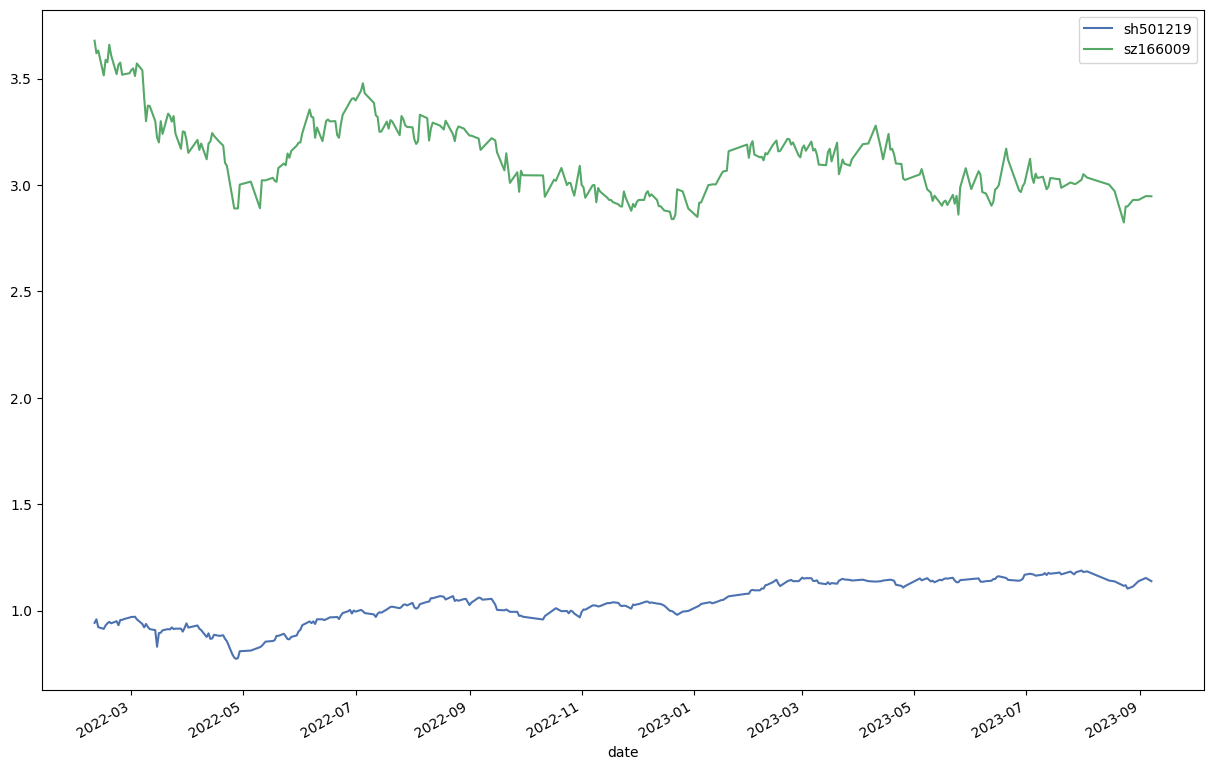

In [210]:
# 1.portfolio = fund + bond + currency etc.
# 股票型基金收盘价 data_fund("sh501219", "20230101", "20230630")[['date']]
def data_fund(code, start, end):
    dataframe_fund = ak.stock_zh_index_daily_em(symbol = code, start_date = start, end_date = end)
    dataframe_fund.insert(0,column=code, value=dataframe_fund['close'])
    return dataframe_fund[['date',code]]
# 导入组合各基金收盘价
# portfolio(["sh000300"], "20120101", "20230630")
# portfolio(["sh000300","sh501219","sz166009"], "20120101", "20230630")
def portfolio(code,start,end):
    res = data_fund(code[0],start,end)[['date']]
    for i in range(0,len(code)):
        dataframe = data_fund(code[i], start, end)
        res = pd.merge(res, dataframe, how='outer', on = 'date') 
    res.rename(columns={'date': 'datetime'}, inplace=True)
    res.insert(0,column='date', value=pd.to_datetime(res['datetime']))
    res.set_index('date', inplace=True)
    res=res.drop('datetime', axis=1)
    return res.dropna() 
# GFC后收盘价走势
def graph(portfolio,datetime):
    portfolio[portfolio.index>= datetime].plot(figsize=(15,10));
    return pylab.show()
portfolio1=portfolio(["sh501219","sz166009"], "20120101", today)
graph(portfolio1,"2008-01-01")

In [211]:
portfolio1

,sh501219,sz166009
date,,
2022-02-09,0.943,3.678
2022-02-10,0.960,3.619
2022-02-11,0.923,3.632
2022-02-14,0.915,3.515
2022-02-15,0.931,3.588
...,...,...
2023-08-25,1.104,2.899
2023-08-28,1.114,2.930
2023-08-31,1.139,2.930


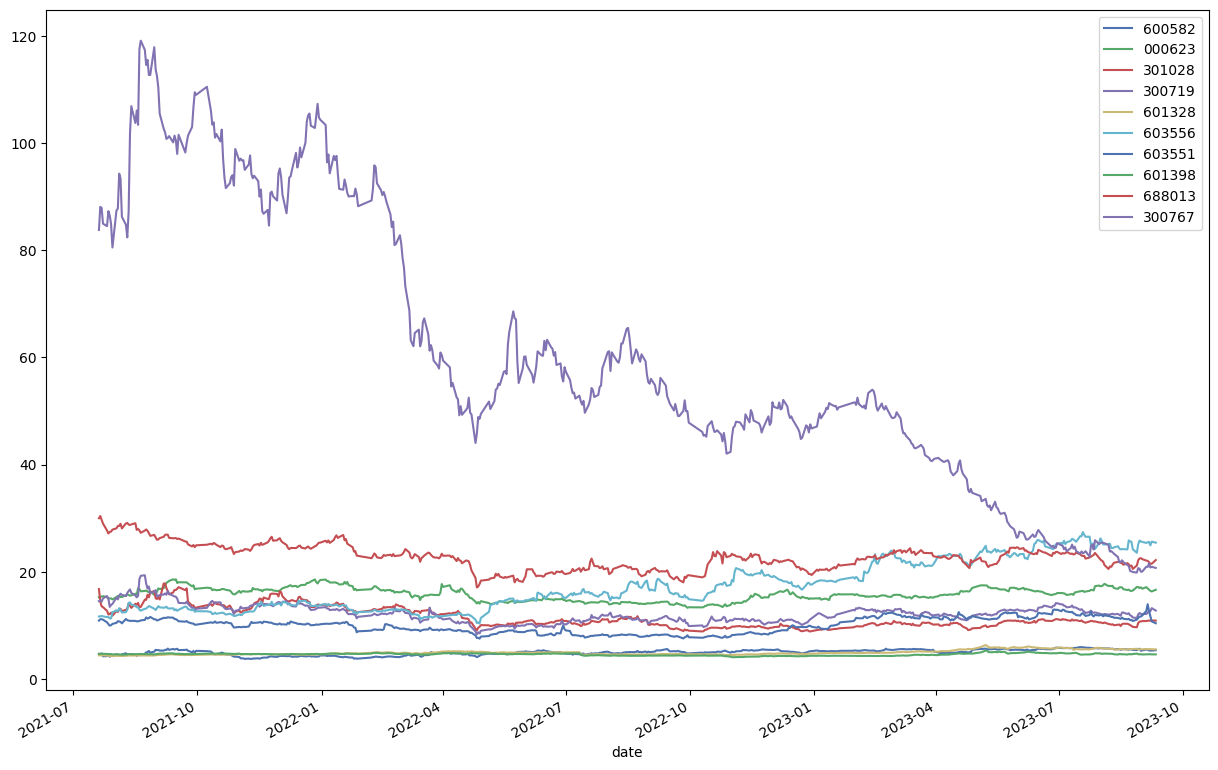

In [212]:
# 2.portfolio = equity1 + equity2 + equity3 etc.
# 股票收盘价 data_equity("600129","20230401",today)
def data_equity(code, start, end):
    dataframe_equity = ak.stock_zh_a_hist(symbol=code, period="daily", start_date = start, end_date = end, adjust="")
    dataframe_equity.insert(0,column=code, value=dataframe_equity['收盘'])
    dataframe_equity.insert(0,column='date', value=dataframe_equity['日期'])
    return dataframe_equity[['date',code]]
# 基金各股票 all_stock("501219","20230301","20230907",2023,1)
def all_stock(fund_code,start,end,year,Q):
    warnings.simplefilter(action='ignore', category=FutureWarning)
    all=ak.fund_portfolio_hold_em(symbol=fund_code, date=year)
    all=all.loc[all['季度'] == str(year)+'年'+str(Q)+'季度股票投资明细']
    all.insert(0,column=fund_code, value=all['股票代码'])
    return all[[fund_code]]
# 前十重仓股票收盘价 portfolio_stock("501219","20170301","20210907",2023,2,10)
def portfolio_stock(fund_code,start,end,year,Q,top_stock):
    stock_list = all_stock(fund_code,start,end,year,Q)
    res = data_equity(stock_list[fund_code][0],start,end)[['date']]
    for i in range(0,top_stock):
        dataframe=pd.DataFrame()
        dataframe = data_equity(stock_list[fund_code][i], start, end)
        res = pd.merge(res, dataframe, how='outer', on = 'date') 
    res.rename(columns={'date': 'datetime'}, inplace=True)
    res.insert(0,column='date', value=pd.to_datetime(res['datetime']))
    res.set_index('date', inplace=True)
    res=res.drop('datetime', axis=1)
    return res.dropna()
# GFC后收盘价走势
portfolio2=portfolio_stock("501219","20170301",today,2023,2,10)
def graph(portfolio,datetime):
    portfolio[portfolio.index>= datetime].plot(figsize=(15,10));
    return pylab.show()
graph(portfolio2,"2008-01-01")

In [213]:
portfolio2

,600582,000623,301028,300719,601328,603556,603551,601398,688013,300767
date,,,,,,,,,,
2021-07-20,4.57,15.25,16.77,14.53,4.41,11.65,10.89,4.71,29.99,83.78
2021-07-21,4.65,15.31,14.40,14.69,4.41,11.69,11.14,4.69,30.40,88.09
2021-07-22,4.77,15.38,13.56,14.42,4.41,11.75,11.16,4.71,29.69,87.90
2021-07-23,4.24,15.45,13.40,15.04,4.41,11.69,11.06,4.70,29.00,84.96
2021-07-26,4.26,15.26,12.71,15.47,4.35,11.54,10.57,4.67,27.70,84.50
...,...,...,...,...,...,...,...,...,...,...
2023-09-05,5.46,16.90,10.87,12.32,5.55,25.50,13.95,4.59,22.05,20.90
2023-09-06,5.32,16.67,10.91,12.75,5.56,25.58,12.70,4.61,21.79,21.55
2023-09-07,5.31,16.44,10.84,12.63,5.57,24.93,11.72,4.62,21.48,20.80


# Calculation  

portfolio input

In [253]:
portfolio=portfolio2

returns

In [254]:
def table(portfolio,frequency=252):
    total_return=portfolio.iloc[-1, :] / portfolio.iloc[0, :]
    period=(portfolio.index[-1] - portfolio.index[0]).days/365
    mean=total_return**(1 / period) - 1
    std=(portfolio.pct_change()[1:].std())*np.sqrt(frequency)
    res = pd.DataFrame({"mean":mean,"std": std})
    return res
table(portfolio)

,mean,std
600582,0.078097,0.373183
000623,0.041501,0.248969
301028,-0.182301,0.422753
300719,-0.058413,0.462562
601328,0.111263,0.169425
603556,0.438919,0.423258
603551,-0.021233,0.364522
601398,-0.011958,0.150492
688013,-0.131004,0.318922
300767,-0.478614,0.477212


annual returns

In [255]:
def returns(portfolio,frequency=252):
    total_return=portfolio.iloc[-1, :] / portfolio.iloc[0, :]
    period=(portfolio.index[-1] - portfolio.index[0]).days/365
    mean=total_return**(1 / period) - 1
    std=(portfolio.pct_change()[1:].std())*np.sqrt(frequency)
    res = pd.DataFrame({"mean":mean,"std": std})
    return np.array(mean)
returns(portfolio)

array([ 0.07809736,  0.04150079, -0.18230118, -0.05841302,  0.11126297,
        0.438919  , -0.02123275, -0.01195842, -0.13100378, -0.47861362])

covariance matrix

In [256]:
# calculating the covariance matrix
def covariance(portfolio,frequency=252):
    res = portfolio.pct_change().dropna(how="all").cov()*frequency
    return res 
covariance(portfolio)


,600582,000623,301028,300719,601328,603556,603551,601398,688013,300767
600582,0.139265,0.022135,0.033574,0.034123,0.010681,0.045348,0.024002,0.003262,0.020153,0.033255
000623,0.022135,0.061986,0.026924,0.016696,0.016610,0.021913,0.024175,0.009973,0.029663,0.019916
301028,0.033574,0.026924,0.178720,0.050256,0.008095,0.063115,0.045771,0.002005,0.054985,0.037362
300719,0.034123,0.016696,0.050256,0.213964,0.003656,0.048268,0.039102,-0.001390,0.044879,0.048791
601328,0.010681,0.016610,0.008095,0.003656,0.028705,0.005351,0.006196,0.019307,0.005484,0.007624
603556,0.045348,0.021913,0.063115,0.048268,0.005351,0.179148,0.029079,0.000055,0.039679,0.034758
603551,0.024002,0.024175,0.045771,0.039102,0.006196,0.029079,0.132876,0.002945,0.037928,0.021452
601398,0.003262,0.009973,0.002005,-0.001390,0.019307,0.000055,0.002945,0.022648,0.000327,0.002736
688013,0.020153,0.029663,0.054985,0.044879,0.005484,0.039679,0.037928,0.000327,0.101711,0.030294
300767,0.033255,0.019916,0.037362,0.048791,0.007624,0.034758,0.021452,0.002736,0.030294,0.227731


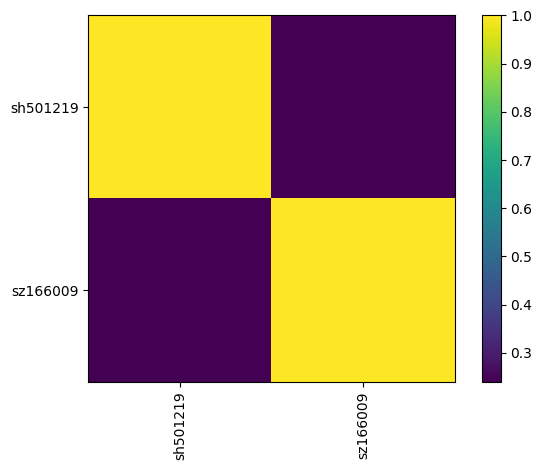

In [257]:
plotting.plot_covariance(covariance(portfolio1), plot_correlation=True);
# pylab.show()

optimized weights

In [258]:
# optimized weights with minimum variance given target mean and conditions on weights
def optimization_var(returns,sample_cov,target=0.15, L=0, H=1): # Set the target mean return
    n = len(returns) # Total number of assets
    initial_weights = np.ones(n) / n # Initial guess for weights
    def objective_function(weights, cov_matrix): # Define the objective function to minimize (variance of the portfolio)
        return weights.dot(cov_matrix).dot(weights)
    constraints = ({'type': 'eq', 'fun': lambda weights: np.dot(weights, returns) - target},  # target return
    {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
    bounds = [(L, H) for _ in range(n)] # Set bounds for weights (between 0 and 1)
    result = scipy.optimize.minimize(objective_function, initial_weights, args=(sample_cov,), constraints=constraints, bounds=bounds)
    return "Optimal weights:"+str(result.x)+". Minimum portfolio variance:"+str(result.fun) 
optimization_var(returns(portfolio),covariance(portfolio))    

'Optimal weights:[2.38150685e-02 2.04039933e-02 5.99021700e-18 4.60785923e-19\n 6.02541593e-01 1.87947098e-01 2.84829411e-02 1.36809307e-01\n 2.38524478e-18 0.00000000e+00]. Minimum portfolio variance:0.02377912459426411'

# Alternative method

In [259]:
import pypfopt 
#https://pyportfolioopt.readthedocs.io/en/latest/UserGuide.html 
#https://github.com/robertmartin8/PyPortfolioOpt/tree/master/cookbook
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt.expected_returns import mean_historical_return

portfolio

In [260]:
ef = EfficientFrontier(returns(portfolio), risk_models.sample_cov(portfolio, frequency=252))
ef.efficient_return(0.15) #minimises risk for a given target return

OrderedDict([('600582', 0.0242095345635222),
             ('000623', 0.019678997297557),
             ('301028', 0.0),
             ('300719', 0.0),
             ('601328', 0.6028304534146234),
             ('603556', 0.1878983293815737),
             ('603551', 0.0296012322739102),
             ('601398', 0.1357814530688134),
             ('688013', 0.0),
             ('300767', 0.0)])

In [261]:
ef = EfficientFrontier(returns(portfolio), risk_models.sample_cov(portfolio, frequency=252))
ef.min_volatility() #optimizes for minimum volatility

OrderedDict([('600582', 0.0469084478585682),
             ('000623', 0.0436127196880795),
             ('301028', 0.0050538170380384),
             ('300719', 0.0292787585436622),
             ('601328', 0.050332140227695),
             ('603556', 0.0323647987471758),
             ('603551', 0.0451372429028418),
             ('601398', 0.6418696386999815),
             ('688013', 0.0810256481612675),
             ('300767', 0.02441678813269)])

In [262]:
ef = EfficientFrontier(returns(portfolio), risk_models.sample_cov(portfolio, frequency=252))
ef.max_sharpe() #optimizes for maximal Sharpe ratio (a.k.a the tangency portfolio)

OrderedDict([('600582', 0.0),
             ('000623', 0.0),
             ('301028', 0.0),
             ('300719', 0.0),
             ('601328', 0.5501329273858468),
             ('603556', 0.4498670726141532),
             ('603551', 0.0),
             ('601398', 0.0),
             ('688013', 0.0),
             ('300767', 0.0)])

In [263]:
ef = EfficientFrontier(returns(portfolio), risk_models.sample_cov(portfolio, frequency=252))
ef.efficient_risk(0.5) #maximises return for a given target risk

OrderedDict([('600582', 6.223299e-10),
             ('000623', 5.099823e-10),
             ('301028', 4.24496e-10),
             ('300719', 3.923427e-10),
             ('601328', 4.231001e-10),
             ('603556', 0.9999999960826556),
             ('603551', 4.758322e-10),
             ('601398', 4.311181e-10),
             ('688013', 4.254472e-10),
             ('300767', 2.132981e-10)])